## 0.  Google Drive Amount

In [17]:
import os, sys 
from google.colab import drive 
drive.mount('/content/drive') 
nb_path = '/content/drive/My Drive/Colab Notebooks/novel_sentiment_analysis'

os.chdir(nb_path)
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/My Drive/Colab Notebooks/novel_sentiment_analysis'

## 1. Importing Library

In [18]:
import multiprocessing

from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
# !python -m spacy download en
# !python -m spacy download en_core_web_sm

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


# visualization
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import nltk
nltk.download('wordnet')
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


## 2. Loading Text File

In [19]:
file_path = 'the_overcoat.txt'

text_data = []
with open(file_path) as f:
    while True:
        line = f.readline()
        if line == '\n': # delete new line mark
            continue
        line = line.replace('\n', '') # delete new line mark in end of each sentence
        if not line:
            break
        text_data.append(line)

print(text_data[:5])

['The Overcoat', "In the department of—but it is better not to mention the department. There is nothing more irritable than departments, regiments, courts of justice, and, in a word, every branch of public service. Each individual attached to them nowadays thinks all society insulted in his person. Quite recently a complaint was received from a justice of the peace, in which he plainly demonstrated that all the imperial institutions were going to the dogs, and that the Czar's sacred name was being taken in vain; and in proof he appended to the complaint a romance in which the justice of the peace is made to appear about once every ten lines, and sometimes in a drunken condition. Therefore, in order to avoid all unpleasantness, it will be better to describe the department in question only as a certain department.", 'So, in a certain department there was a certain official—not a very high one, it must be allowed—short of stature, somewhat pock-marked, red-haired, and short-sighted, with 

## 3. Checking Text Data Frame

In [20]:
text_df = pd.DataFrame(text_data)
text_df.columns = ['sentence']
print("\n")
print("#"*60)
print("head of text data frame")
print(text_df.head(10))
print(text_df.tail(10))



############################################################
head of text data frame
                                            sentence
0                                       The Overcoat
1  In the department of—but it is better not to m...
2  So, in a certain department there was a certai...
3  His family name was Bashmachkin. This name is ...
4                         This is how it came about.
5  Akakiy Akakievitch was born, if my memory fail...
6  since such is the case, it will be better to n...
7  In this manner did it all come about. We have ...
8  The young officials laughed at and made fun of...
9  It would be difficult to find another man who ...
                                              sentence
93   A rumour suddenly spread through St. Petersbur...
94   Arrangements were made by the police to catch ...
95   But we have totally neglected that certain pro...
96   Wishing to divert his mind in some way, and dr...
97   It must be mentioned that the prominent person...


## 4. Preprocessing Text Data

In [21]:
t = time()
print("\n")
print("#"*60)

print("loading spacy preprocessor...")

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed
# nlp = spacy.load("en_core_web_sm")

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)


print("lower, remove special token...")
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in text_df['sentence'])

print("lemmatizing, removing stopwords, removing short sentence...")
txt = [cleaning(text_df) for text_df in nlp.pipe(brief_cleaning, batch_size=5000)]


text_df_clean = pd.DataFrame({'preprocessed_sentence': txt})
print("drop NA, drop duplicates...")
text_df_clean = text_df_clean.dropna().drop_duplicates()
print()
print(text_df_clean.shape)
print(text_df_clean.head(10))
print()


print()
print('Using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences...')
sentences = [row.split() for row in text_df_clean['preprocessed_sentence']]
bigram_model = Phrases(sentences, min_count=30, progress_per=10000)

print("example of bigram vocab")
list(bigram_model.vocab.keys())[:5]

print("change senteces using bigram...")
for i, sentence in enumerate(sentences):
    bigram_s = bigram_model[sentence]
    if sentence != bigram_s:
        sentences[i] = bigram_s
        #print(f'{i}\t', "--"*20)
        #print(f"raw    sentences: {sentence}")
        #print(f"Bigram sentences: {bigram_s}")
print()
print("example of preprocesed sentences")
for i in range(5):
    print(f"sentence {i}: \t", sentences[i])
print()


# word frequency check
"""
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
print(len(word_freq))
sorted(word_freq, key=word_freq.get, reverse=True)[:10]
"""

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))



############################################################
loading spacy preprocessor...
lower, remove special token...
lemmatizing, removing stopwords, removing short sentence...


INFO - 08:33:54: collecting all words and their counts
INFO - 08:33:54: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 08:33:54: collected 6220 word types from a corpus of 4865 words (unigram + bigrams) and 101 sentences
INFO - 08:33:54: using 6220 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


drop NA, drop duplicates...

(101, 1)
                                preprocessed_sentence
1   department well mention department irritable d...
2   certain department certain official high allow...
3   family bashmachkin evidently derive bashmak sh...
5   akakiy akakievitch bear memory fail evening rd...
6   case well father father akakiy let son akakiy ...
7   manner come mention order reader case necessit...
8   young official laugh fun far official wit perm...
9   difficult find man live entirely duty akakiy l...
10  impossible attention pay director kindly man d...
11  outside copying appear exist give thought clot...


Using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences...
example of bigram vocab
change senteces using bigram...

example of preprocesed sentences
sentence 0: 	 ['department', 'well', 'mention', 'department', 'irritable', 'department', 'regiment', 'court', 'justice', 'word', 'branch', 'public', 'service', 'individua

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


## 5. Training Word2Vec Model

In [22]:
t = time()

print("\n")
print("#"*60)
print()
print("CPU check...")
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print("the number of processor: ", cores)
print()

print("Define Word2Vec Model...")
size = 300
window = 2
print("the size of dimensions of each word vector: ", size)
print("the size of window: ", size)
w2v_model = Word2Vec(min_count=5,
                     window=window,
                     size=size,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

print()
print("buiding vocabulary...")
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
print()


t = time()
print("training Word2Vec model...")
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=1000, report_delay=1)
print("training is done...")
print()

print("saving trained word2vec model...")
file_path = './word2vec_model/the_overcoat_w2v_model.model'
print("file path:\t", file_path)
w2v_model.save(file_path)
print()

print("loading saved word2vec model...")
w2v_model = Word2Vec.load(file_path)
print()

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))
print()

INFO - 08:33:54: collecting all words and their counts
INFO - 08:33:54: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 08:33:54: collected 1784 word types from a corpus of 4776 raw words and 101 sentences
INFO - 08:33:54: Loading a fresh vocabulary
INFO - 08:33:54: effective_min_count=5 retains 209 unique words (11% of original 1784, drops 1575)
INFO - 08:33:54: effective_min_count=5 leaves 2320 word corpus (48% of original 4776, drops 2456)
INFO - 08:33:54: deleting the raw counts dictionary of 1784 items
INFO - 08:33:54: sample=6e-05 downsamples 209 most-common words
INFO - 08:33:54: downsampling leaves estimated 273 word corpus (11.8% of prior 2320)
INFO - 08:33:54: estimated required memory for 209 words and 300 dimensions: 606100 bytes
INFO - 08:33:54: resetting layer weights
INFO - 08:33:54: training model with 1 workers on 209 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2




############################################################

CPU check...
the number of processor:  2

Define Word2Vec Model...
the size of dimensions of each word vector:  300
the size of window:  300

buiding vocabulary...
Time to build vocab: 0.0 mins

training Word2Vec model...


INFO - 08:33:54: worker thread finished; awaiting finish of 0 more threads
INFO - 08:33:54: EPOCH - 1 : training on 4776 raw words (249 effective words) took 0.0s, 41817 effective words/s
INFO - 08:33:54: worker thread finished; awaiting finish of 0 more threads
INFO - 08:33:54: EPOCH - 2 : training on 4776 raw words (257 effective words) took 0.0s, 32973 effective words/s
INFO - 08:33:54: worker thread finished; awaiting finish of 0 more threads
INFO - 08:33:54: EPOCH - 3 : training on 4776 raw words (267 effective words) took 0.0s, 44060 effective words/s
INFO - 08:33:54: worker thread finished; awaiting finish of 0 more threads
INFO - 08:33:54: EPOCH - 4 : training on 4776 raw words (242 effective words) took 0.0s, 40939 effective words/s
INFO - 08:33:54: worker thread finished; awaiting finish of 0 more threads
INFO - 08:33:54: EPOCH - 5 : training on 4776 raw words (281 effective words) took 0.0s, 46259 effective words/s
INFO - 08:33:54: worker thread finished; awaiting finish of 

training is done...

saving trained word2vec model...
file path:	 ./word2vec_model/the_overcoat_w2v_model.model


INFO - 08:34:10: saved ./word2vec_model/the_overcoat_w2v_model.model
INFO - 08:34:10: loading Word2Vec object from ./word2vec_model/the_overcoat_w2v_model.model
INFO - 08:34:10: loading wv recursively from ./word2vec_model/the_overcoat_w2v_model.model.wv.* with mmap=None
INFO - 08:34:10: setting ignored attribute vectors_norm to None
INFO - 08:34:10: loading vocabulary recursively from ./word2vec_model/the_overcoat_w2v_model.model.vocabulary.* with mmap=None
INFO - 08:34:10: loading trainables recursively from ./word2vec_model/the_overcoat_w2v_model.model.trainables.* with mmap=None
INFO - 08:34:10: setting ignored attribute cum_table to None
INFO - 08:34:10: loaded ./word2vec_model/the_overcoat_w2v_model.model



loading saved word2vec model...

Time to train the model: 0.27 mins



## 6. Word Embedding

In [23]:
print("\n")
print("#"*60)
print("checking word embeddings...")

word_vectors = w2v_model.wv
print("total number of words: ", len(word_vectors.index2word))
print()
print("5 example of word vectors")
for i in range(5):
    word = word_vectors.index2word[i]
    print(f"[{i+1}]: \t", word)
    print(word_vectors.get_vector(word))



############################################################
checking word embeddings...
total number of words:  209

5 example of word vectors
[1]: 	 akakiy_akakievitch
[-0.04554073 -0.12588446 -0.09769367  0.08595052  0.0476548  -0.03837301
 -0.0291047   0.12430871 -0.09315231  0.0284563   0.1469127   0.08190434
  0.03701407 -0.31148836  0.00691564 -0.1489322  -0.11967735 -0.0777944
 -0.1634333   0.1380283   0.04636824 -0.16868137  0.0328068   0.2777363
  0.0412016   0.00948285 -0.07432928  0.14403023  0.12357025 -0.01468777
 -0.09579299 -0.00648911 -0.05232726  0.02549877  0.09847818  0.08929347
  0.02000796 -0.07208318 -0.06163206  0.07728388  0.12681112  0.00462046
  0.06849992  0.0091706  -0.17065908  0.28044215 -0.05717073  0.22451462
 -0.0628447   0.05316371  0.13895297 -0.15465061  0.0807889   0.0219539
  0.03134413  0.0075673  -0.04114866  0.12317904 -0.12211597 -0.06273285
  0.02623166  0.19181332 -0.10014307 -0.01361473  0.1396409  -0.07684576
  0.02356255  0.12696037  0.

## 7. Location Sentiment Analysis
### - Querying location and Selecting k-nearest neighbor words

In [24]:
print("\n")
print("#"*60)
print("Querying location word in word embeddings...")
print()

location = 'petersburg'
k = 20
print(f"target location word: \t {location}")
print(f"the number of neighbor words: \t {k}")

print()
print("k-nearest neighbor words")
k_neighbors = word_vectors.most_similar(positive=[location], topn=k)
print("No. word \t\tdistance")
for i, (neighbor_word, distance) in enumerate(k_neighbors):
    print(f"{i+1}. {neighbor_word}\t\t {distance}")
    

INFO - 08:34:10: precomputing L2-norms of word weight vectors




############################################################
Querying location word in word embeddings...

target location word: 	 petersburg
the number of neighbor words: 	 20

k-nearest neighbor words
No. word 		distance
1. st		 0.9980970621109009
2. official		 0.907179594039917
3. form		 0.8938503861427307
4. street		 0.8911744952201843
5. live		 0.8896898627281189
6. descend		 0.8864911794662476
7. hour		 0.8835703134536743
8. appear		 0.882817804813385
9. cold		 0.8684929013252258
10. skin		 0.8621017336845398
11. poor		 0.8554055690765381
12. life		 0.8504716157913208
13. certain		 0.8473800420761108
14. leave		 0.8449028134346008
15. foot		 0.8441869020462036
16. quarter		 0.8413866758346558
17. titular		 0.8325337171554565
18. councillor		 0.8266780972480774
19. world		 0.825907826423645
20. show		 0.8169169425964355


### - Applying sentiment score to each selected words


In [25]:
print("\n")
print("#"*60)
print("example of SentiWordNet Senti-Synsets...")
print()

target_word = 'good'
print("target word: ", target_word)

def synset_senti_score(target_word):
    synsets = swn.senti_synsets(target_word)
    print('synset name\tpositive \tnegative \tobjective')
    for ss in synsets:
        print(ss.synset.name(),"\t", ss.pos_score(), "\t\t", ss.neg_score(), "\t\t", ss.obj_score())

print(f"sentiment score of synsets of {target_word}")
synset_senti_score(target_word)



############################################################
example of SentiWordNet Senti-Synsets...

target word:  good
sentiment score of synsets of good
synset name	positive 	negative 	objective
good.n.01 	 0.5 		 0.0 		 0.5
good.n.02 	 0.875 		 0.0 		 0.125
good.n.03 	 0.625 		 0.0 		 0.375
commodity.n.01 	 0.0 		 0.0 		 1.0
good.a.01 	 0.75 		 0.0 		 0.25
full.s.06 	 0.0 		 0.0 		 1.0
good.a.03 	 1.0 		 0.0 		 0.0
estimable.s.02 	 1.0 		 0.0 		 0.0
beneficial.s.01 	 0.625 		 0.0 		 0.375
good.s.06 	 1.0 		 0.0 		 0.0
good.s.07 	 0.75 		 0.0 		 0.25
adept.s.01 	 0.625 		 0.0 		 0.375
good.s.09 	 0.625 		 0.0 		 0.375
dear.s.02 	 0.5 		 0.0 		 0.5
dependable.s.04 	 0.5 		 0.0 		 0.5
good.s.12 	 0.375 		 0.0 		 0.625
good.s.13 	 0.625 		 0.0 		 0.375
effective.s.04 	 0.0 		 0.0 		 1.0
good.s.15 	 0.625 		 0.0 		 0.375
good.s.16 	 0.75 		 0.0 		 0.25
good.s.17 	 0.75 		 0.0 		 0.25
good.s.18 	 0.875 		 0.0 		 0.125
good.s.19 	 0.5 		 0.0 		 0.5
good.s.20 	 0.375 		 0.125 		 0.5
goo

In [26]:
print("\n")
print("#"*60)

obj_threshold = 0.25

print("custom sentiment score")
print(f"1) if objective score <= {obj_threshold}, then the synset is used for sentiment analyis...")
print("2) mean of (positive score - negative score) of each synset is the final sentiment score")
print("maximum positive score: 1, maximm negative score: -1, neutral: 0 \t range(-1~1)")
print()
print("example of custom sentiment score")
print()



def synset_senti_score(target_word, obj_threshold):
    synsets = swn.senti_synsets(target_word)
    print("target word: ", target_word)
    print('synset name\tpositive \tnegative \tobjective')
    senti_score_list = []
    for ss in synsets:
        pos = ss.pos_score()
        neg = ss.neg_score()
        obj = ss.obj_score()
        if obj <= obj_threshold:
            print(ss.synset.name(),"\t", pos, "\t\t", neg, "\t\t", obj, '\t(used for SA)')
            senti_score_list.append(pos-neg)
        else:
            print(ss.synset.name(),"\t", pos, "\t\t", neg, "\t\t", obj)
    
    if len(senti_score_list) == 0:
        senti_score = 0.
    else:
        senti_score = np.mean(senti_score_list)
    
    return senti_score

print()
target_word = 'good'
print(f"\nsentiment score of '{target_word}': {synset_senti_score(target_word, obj_threshold)}")
print("-"*50)

print()
target_word = 'bad'
print(f"\nsentiment score of '{target_word}': {synset_senti_score(target_word, obj_threshold)}")
print("-"*50)

print()
target_word = 'school'
print(f"\nsentiment score of '{target_word}': {synset_senti_score(target_word, obj_threshold)}")
print("-"*50)



############################################################
custom sentiment score
1) if objective score <= 0.25, then the synset is used for sentiment analyis...
2) mean of (positive score - negative score) of each synset is the final sentiment score
maximum positive score: 1, maximm negative score: -1, neutral: 0 	 range(-1~1)

example of custom sentiment score


target word:  good
synset name	positive 	negative 	objective
good.n.01 	 0.5 		 0.0 		 0.5
good.n.02 	 0.875 		 0.0 		 0.125 	(used for SA)
good.n.03 	 0.625 		 0.0 		 0.375
commodity.n.01 	 0.0 		 0.0 		 1.0
good.a.01 	 0.75 		 0.0 		 0.25 	(used for SA)
full.s.06 	 0.0 		 0.0 		 1.0
good.a.03 	 1.0 		 0.0 		 0.0 	(used for SA)
estimable.s.02 	 1.0 		 0.0 		 0.0 	(used for SA)
beneficial.s.01 	 0.625 		 0.0 		 0.375
good.s.06 	 1.0 		 0.0 		 0.0 	(used for SA)
good.s.07 	 0.75 		 0.0 		 0.25 	(used for SA)
adept.s.01 	 0.625 		 0.0 		 0.375
good.s.09 	 0.625 		 0.0 		 0.375
dear.s.02 	 0.5 		 0.0 		 0.5
dependable.s.04 	

In [27]:
print("\n")
print("#"*60)
print("location sentiment analysis...")

def senti_score(target_word, obj_threshold):
    synsets = swn.senti_synsets(target_word)
    senti_score_list = []
    print(f"\n\ttarget word: {target_word}")
    print('\t\tsynset name\tpositive \tnegative \tobjective')
    for ss in synsets:
        pos = ss.pos_score()
        neg = ss.neg_score()
        obj = ss.obj_score()
        if obj <= obj_threshold:
            print("\t\t", ss.synset.name(),"\t", pos, "\t\t", neg, "\t\t", obj, '\t(used for SA)')
            senti_score_list.append(pos-neg)
        else:
            print("\t\t", ss.synset.name(),"\t", pos, "\t\t", neg, "\t\t", obj)
    if len(senti_score_list) == 0:
        senti_score = 0.
    else:
        senti_score = np.mean(senti_score_list)
    
    print(f"\t sentiment score of '{target_word}': {senti_score}")
    return senti_score

query = 'petersburg'
print("Query: ", query)

neighbor_words = []
for neighbor_word in w2v_model.wv.most_similar(positive=[query]):
    neighbor_words.append(neighbor_word[0])
print("K-neigbor words: ", neighbor_words)

neighbor_senti_scores = []
used_neighbor_list = []
for neighbor in neighbor_words:
    score = senti_score(neighbor, obj_threshold=0.5)
    if score != 0:
        used_neighbor_list.append(neighbor)
        neighbor_senti_scores.append(score)

print()
print("used neighbor words \t", used_neighbor_list)
print("sentiment score of each neighbor word \t", neighbor_senti_scores)

print(f"final sentiment score of '{query}': \t {np.mean(neighbor_senti_scores)}")




############################################################
location sentiment analysis...
Query:  petersburg
K-neigbor words:  ['st', 'official', 'form', 'street', 'live', 'descend', 'hour', 'appear', 'cold', 'skin']

	target word: st
		synset name	positive 	negative 	objective
	 sentiment score of 'st': 0.0

	target word: official
		synset name	positive 	negative 	objective
		 official.n.01 	 0.0 		 0.0 		 1.0
		 official.n.02 	 0.0 		 0.0 		 1.0
		 official.a.01 	 0.0 		 0.0 		 1.0
		 official.a.02 	 0.0 		 0.0 		 1.0
		 official.s.03 	 0.0 		 0.0 		 1.0
		 official.s.04 	 0.25 		 0.0 		 0.75
		 official.s.05 	 0.0 		 0.0 		 1.0
	 sentiment score of 'official': 0.0

	target word: form
		synset name	positive 	negative 	objective
		 form.n.01 	 0.0 		 0.0 		 1.0
		 kind.n.01 	 0.0 		 0.0 		 1.0
		 form.n.03 	 0.0 		 0.0 		 1.0
		 shape.n.01 	 0.0 		 0.0 		 1.0
		 human_body.n.01 	 0.0 		 0.0 		 1.0
		 shape.n.02 	 0.0 		 0.0 		 1.0
		 form.n.07 	 0.0 		 0.0 		 1.0
		 form.n.08 	 0.

In [28]:
def location_sentiment_analysis(query, w2v_model, num_k, obj_threshold):
    print("Query: ", query)
    
    neighbor_words = []
    neighbor_distances = []
    for neighbor_word in w2v_model.wv.most_similar(positive=[query], topn=num_k):
        neighbor_words.append(neighbor_word[0])
        neighbor_distances.append(neighbor_word[1])
    print("K-neigbor words: ", neighbor_words)
    print("K-neigbor distances: ", neighbor_distances)
    
    neighbor_senti_scores = []
    used_neighbor_list = []
    for neighbor in neighbor_words:
        score = senti_score(neighbor, obj_threshold=obj_threshold)
        if score != 0:
            used_neighbor_list.append(neighbor)
            neighbor_senti_scores.append(score)    
    
    print()
    print("used neighbor words \t", used_neighbor_list)
    print("sentiment score of each neighbor word \t", neighbor_senti_scores)
    
    sentiment_score = np.mean(neighbor_senti_scores)
    print(f"final sentiment score of '{query}': \t {sentiment_score}")
    
    return query, neighbor_words, used_neighbor_list, sentiment_score

## 7. Location Sentiment Analysis Results

In [29]:
print("\n")
print("#"*60)
location_sentiment_analysis(query='petersburg', w2v_model=w2v_model, num_k=20, obj_threshold=0.5)



############################################################
Query:  petersburg
K-neigbor words:  ['st', 'official', 'form', 'street', 'live', 'descend', 'hour', 'appear', 'cold', 'skin', 'poor', 'life', 'certain', 'leave', 'foot', 'quarter', 'titular', 'councillor', 'world', 'show']
K-neigbor distances:  [0.9980970621109009, 0.907179594039917, 0.8938503861427307, 0.8911744952201843, 0.8896898627281189, 0.8864911794662476, 0.8835703134536743, 0.882817804813385, 0.8684929013252258, 0.8621017336845398, 0.8554055690765381, 0.8504716157913208, 0.8473800420761108, 0.8449028134346008, 0.8441869020462036, 0.8413866758346558, 0.8325337171554565, 0.8266780972480774, 0.825907826423645, 0.8169169425964355]

	target word: st
		synset name	positive 	negative 	objective
	 sentiment score of 'st': 0.0

	target word: official
		synset name	positive 	negative 	objective
		 official.n.01 	 0.0 		 0.0 		 1.0
		 official.n.02 	 0.0 		 0.0 		 1.0
		 official.a.01 	 0.0 		 0.0 		 1.0
		 official.a.02 	 0.

('petersburg',
 ['st',
  'official',
  'form',
  'street',
  'live',
  'descend',
  'hour',
  'appear',
  'cold',
  'skin',
  'poor',
  'life',
  'certain',
  'leave',
  'foot',
  'quarter',
  'titular',
  'councillor',
  'world',
  'show'],
 ['live', 'descend', 'cold', 'poor', 'show'],
 0.0958333333333333)

## 8. Visualization

In [30]:
# 1) Query(red) / 2) Neighbor(blue) / 3) used Neighbor(green) / 4)ohter words(purple) 

def scatterplot(model, query, neighbor_words, used_neighbor_list, other_words_list=None, method='pca'):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [query]
    color_list  = ['red']
    

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([query]), axis=0)
    
    # adds the vector for each of the closest words to the array
    for neighbor in neighbor_words:
        wrd_vector = model.wv.__getitem__([neighbor])
        word_labels.append(neighbor)
        if neighbor in used_neighbor_list:
            color_list.append('green')
        else:
            color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # adds the vector for each of the closest words to the array
    #for used_neighbor in used_neighbor_list:
    #    wrd_vector = model.wv.__getitem__([used_neighbor])
    #    word_labels.append(used_neighbor)
    #    color_list.append('green')
    #    arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    if other_words_list != None:
        for wrd in other_words_list:
            wrd_vector = model.wv.__getitem__([wrd])
            word_labels.append(wrd)
            color_list.append('purple')
            arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    if method == 'pca':
        Y = PCA(n_components=2).fit_transform(arrays)
    elif method == 'tsne':
        # Finds t-SNE coordinates for 2 dimensions
        np.set_printoptions(suppress=True)
        Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(arrays)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(20, 20)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
        
        p1.text(df["x"][line],
                df['y'][line],
                '  ' + df["words"][line].title(),
                horizontalalignment='left',
                verticalalignment='bottom', size='medium',
                color=df['color'][line],
                weight='normal'
                ).set_size(25)

    extra_size = 0.5
    plt.xlim(Y[:, 0].min()-extra_size, Y[:, 0].max()+extra_size)
    plt.ylim(Y[:, 1].min()-extra_size, Y[:, 1].max()+extra_size)
    
    title = '{} visualization for "{}" in THE OVERCOAT'.format(method, query)
    plt.title(title)
    plt.savefig(f'./scatter_plot/{title}.png', dpi=300) 



############################################################
Query:  petersburg
K-neigbor words:  ['st', 'official', 'form', 'street', 'live', 'descend', 'hour', 'appear', 'cold', 'skin', 'poor', 'life', 'certain', 'leave', 'foot', 'quarter', 'titular', 'councillor', 'world', 'show']
K-neigbor distances:  [0.9980970621109009, 0.907179594039917, 0.8938503861427307, 0.8911744952201843, 0.8896898627281189, 0.8864911794662476, 0.8835703134536743, 0.882817804813385, 0.8684929013252258, 0.8621017336845398, 0.8554055690765381, 0.8504716157913208, 0.8473800420761108, 0.8449028134346008, 0.8441869020462036, 0.8413866758346558, 0.8325337171554565, 0.8266780972480774, 0.825907826423645, 0.8169169425964355]

	target word: st
		synset name	positive 	negative 	objective
	 sentiment score of 'st': 0.0

	target word: official
		synset name	positive 	negative 	objective
		 official.n.01 	 0.0 		 0.0 		 1.0
		 official.n.02 	 0.0 		 0.0 		 1.0
		 official.a.01 	 0.0 		 0.0 		 1.0
		 official.a.02 	 0.

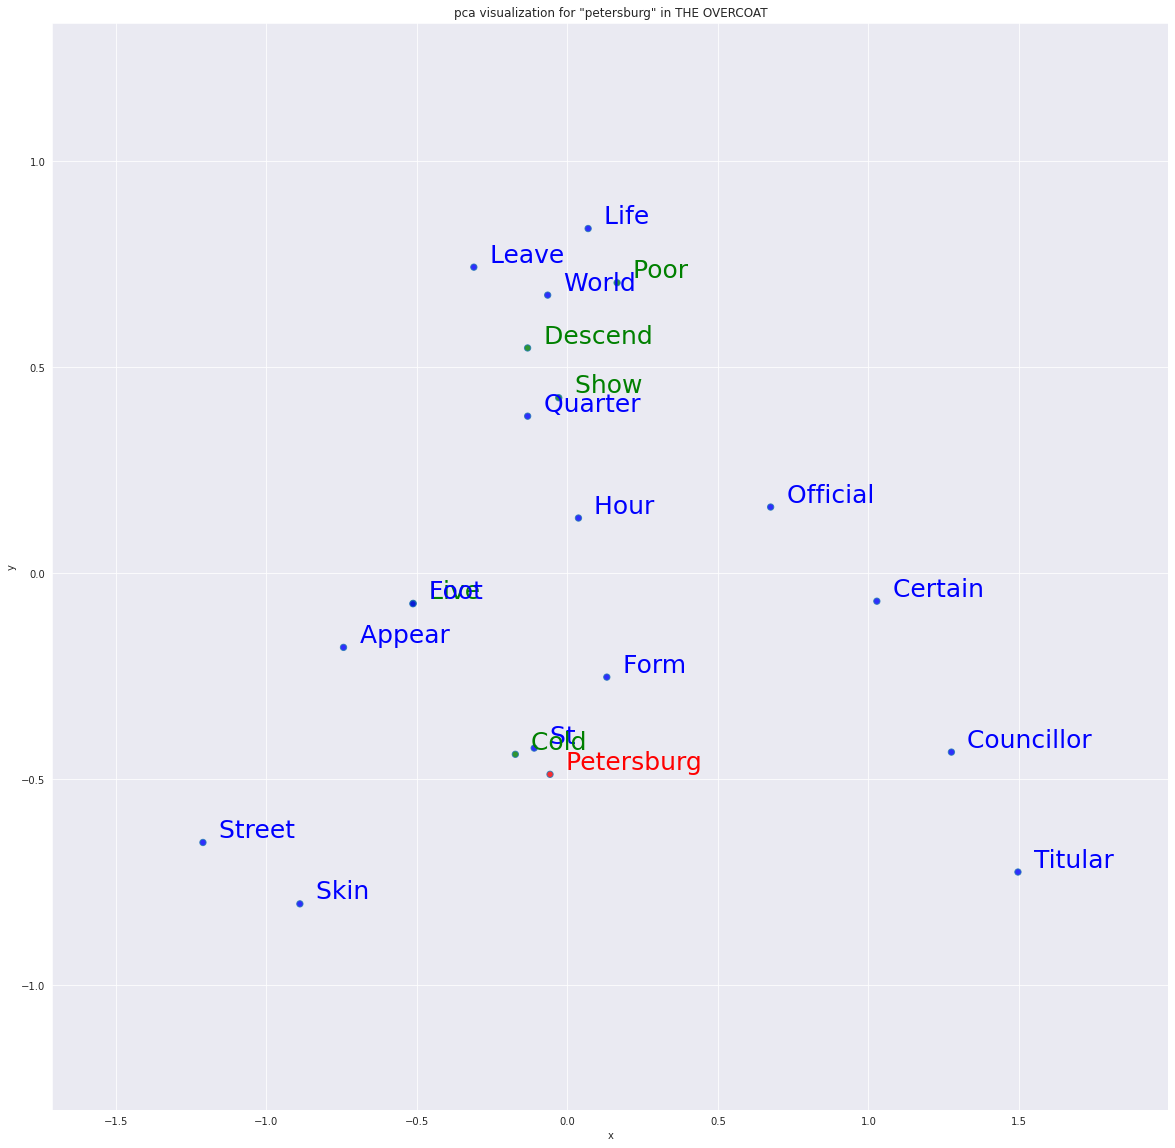

In [31]:
print("\n")
print("#"*60)
query = 'petersburg'
results = location_sentiment_analysis(query=query, w2v_model=w2v_model, num_k=20, obj_threshold=0.5)
query, neighbor_words, used_neighbor_list, sentiment_score = results

print()
scatterplot(w2v_model, query, neighbor_words, used_neighbor_list, other_words_list=[])



############################################################
Query:  petersburg
K-neigbor words:  ['st', 'official', 'form', 'street', 'live', 'descend', 'hour', 'appear', 'cold', 'skin', 'poor', 'life', 'certain', 'leave', 'foot', 'quarter', 'titular', 'councillor', 'world', 'show']
K-neigbor distances:  [0.9980970621109009, 0.907179594039917, 0.8938503861427307, 0.8911744952201843, 0.8896898627281189, 0.8864911794662476, 0.8835703134536743, 0.882817804813385, 0.8684929013252258, 0.8621017336845398, 0.8554055690765381, 0.8504716157913208, 0.8473800420761108, 0.8449028134346008, 0.8441869020462036, 0.8413866758346558, 0.8325337171554565, 0.8266780972480774, 0.825907826423645, 0.8169169425964355]

	target word: st
		synset name	positive 	negative 	objective
	 sentiment score of 'st': 0.0

	target word: official
		synset name	positive 	negative 	objective
		 official.n.01 	 0.0 		 0.0 		 1.0
		 official.n.02 	 0.0 		 0.0 		 1.0
		 official.a.01 	 0.0 		 0.0 		 1.0
		 official.a.02 	 0.

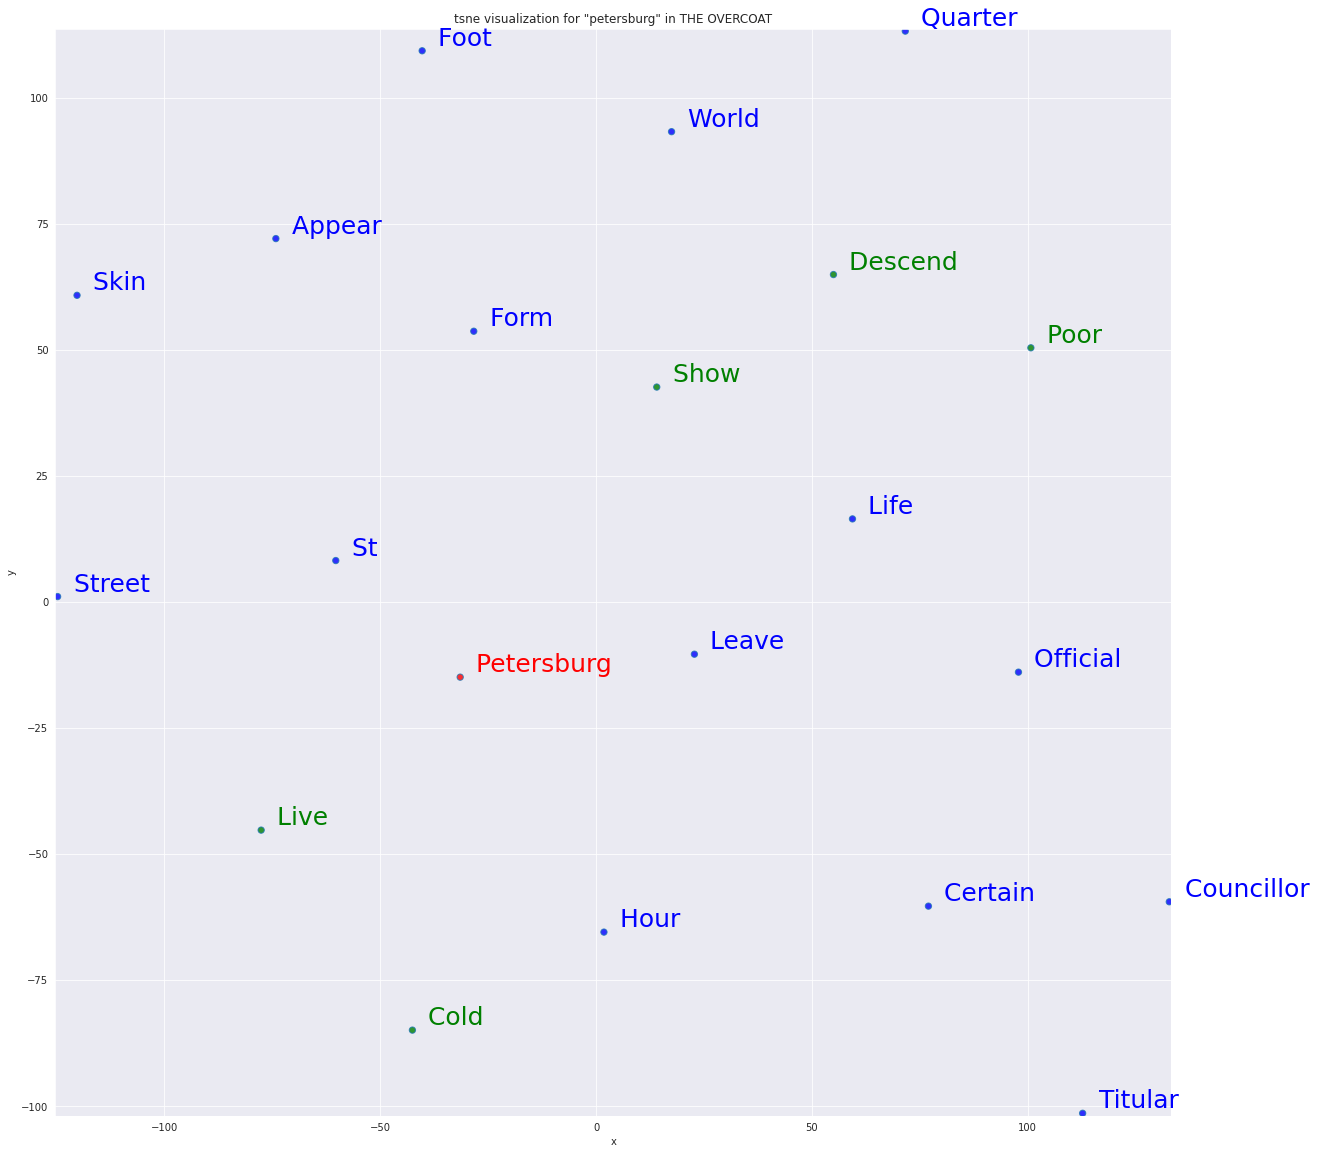

In [32]:
print("\n")
print("#"*60)
query = 'petersburg'
results = location_sentiment_analysis(query=query, w2v_model=w2v_model, num_k=20, obj_threshold=0.5)
query, neighbor_words, used_neighbor_list, sentiment_score = results

print()
scatterplot(w2v_model, query, neighbor_words, used_neighbor_list, other_words_list=[], method='tsne')